# Imports

In [80]:
import string
import json
import re
from collections import Counter
from pathlib import Path

import nltk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from wordcloud import WordCloud

import torch
from torch.utils.data import Dataset
from tqdm import tqdm
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    AutoModelForSeq2SeqLM,
    TrainingArguments, 
    Trainer,
    EarlyStoppingCallback,
)
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Preprocessing

Parse and convert all data to Pandas Dataframes

In [3]:
base_path = Path("semeval2017-task8-dataset/rumoureval-data")
sentiment_file = Path("./semeval2017-task8-dataset/traindev/rumoureval-subtaskA-train.json")
sentiment_file_dev = Path("./semeval2017-task8-dataset/traindev/rumoureval-subtaskA-dev.json")

with open(sentiment_file, 'r') as f:
    sentiment_dict = json.load(f)

with open(sentiment_file_dev, 'r') as f:
    sentiment_dict_dev = json.load(f)

records = []
records_dev = []

for topic_dir in base_path.iterdir():
    topic = topic_dir.name

    for tweet_dir in topic_dir.iterdir():
        source_tweet_id = tweet_dir.name
        
        source_tweet_path = topic_dir / source_tweet_id / "source-tweet" / f"{source_tweet_id}.json"
        with open(source_tweet_path, 'r', encoding='utf-8') as f:
            source_data = json.load(f)
        source_tweet_text = source_data.get('text', '')
        
        replies_dir = tweet_dir / "replies"

        for json_file in replies_dir.glob("*.json"):
            with open(json_file, 'r', encoding='utf-8') as f:
                tweet_data = json.load(f)
            
            tweet_id = str(tweet_data.get('id', ''))

            if sentiment_dict.get(tweet_id):
                record = {
                    'tweet_id': tweet_id,
                    'source_tweet_id': source_tweet_id,
                    'source_tweet_text': source_tweet_text,
                    'topic': topic,
                    'text': tweet_data.get('text', ''),
                    'sentiment': sentiment_dict.get(tweet_id),
                    'source_tweet_sentiment': sentiment_dict.get(source_tweet_id),
                }
                records.append(record)

            elif sentiment_dict_dev.get(tweet_id):
                record = {
                    'tweet_id': tweet_id,
                    'source_tweet_id': source_tweet_id,
                    'source_tweet_text': source_tweet_text,
                    'topic': topic,
                    'text': tweet_data.get('text', ''),
                    'sentiment': sentiment_dict_dev.get(tweet_id),
                    'source_tweet_sentiment': sentiment_dict_dev.get(source_tweet_id),
                }
                records_dev.append(record)

df_train = pd.DataFrame(records)
df_test = pd.DataFrame(records_dev)

Check dataframe and sentiment distribution

In [4]:
df_train

,tweet_id,source_tweet_id,source_tweet_text,topic,text,sentiment,source_tweet_sentiment
0,553549946738446336,553543369604210689,An 11-month old baby is among the hostages at ...,charliehebdo,@PD28 @BklynMiddleton Hashtag #kosher shows lo...,query,support
1,553547724860456961,553543369604210689,An 11-month old baby is among the hostages at ...,charliehebdo,*Mutes Universe*,comment,support
2,553551580801536000,553543369604210689,An 11-month old baby is among the hostages at ...,charliehebdo,@BklynMiddleton rather than being a 'lone-wolf...,query,support
3,553553099470946304,553543369604210689,An 11-month old baby is among the hostages at ...,charliehebdo,@PD28 @BklynMiddleton No problem! Wish it were...,comment,support
4,553544770430464000,553543369604210689,An 11-month old baby is among the hostages at ...,charliehebdo,RT @BklynMiddleton: An 11-month old baby is am...,support,support
...,...,...,...,...,...,...,...
3961,576807061830287360,576796432730071040,Unformed Russian Embassy staff in London have ...,putinmissing,@ShaunyNews hey loved those cool utube vids yo...,comment,support
3962,576797334530580480,576796432730071040,Unformed Russian Embassy staff in London have ...,putinmissing,@ShaunyNews @batchelorshow Did he die during C...,comment,support
3963,576278902185705472,576276947648405505,Coup in #Russia? Good article by @Forbes. http...,putinmissing,#RamzanKadyrov- A Sunni Muslim Russian/Chechen...,deny,support
3964,576281472778182656,576276947648405505,Coup in #Russia? Good article by @Forbes. http...,putinmissing,So if #RamzanKadyrov had #BorisNemtsov assassi...,support,support


In [5]:
df_test

,tweet_id,source_tweet_id,source_tweet_text,topic,text,sentiment,source_tweet_sentiment
0,580325976975896577,580325090367315968,"Flight #4U9525 initially climbed to 38,000 fee...",germanwings-crash,@flightradar24 Any ATC available? Strange.....,query,support
1,581174677554380800,580325090367315968,"Flight #4U9525 initially climbed to 38,000 fee...",germanwings-crash,@marcepa49 The autopilot wasn't set to 100 fee...,support,support
2,581198171176480768,580325090367315968,"Flight #4U9525 initially climbed to 38,000 fee...",germanwings-crash,"@marcepa49 But that's the FMC, doesn't mean au...",comment,support
3,581034556964245504,580325090367315968,"Flight #4U9525 initially climbed to 38,000 fee...",germanwings-crash,@marcepa49 @flightradar24 @isobelroe I don't t...,comment,support
4,581075660690575360,580325090367315968,"Flight #4U9525 initially climbed to 38,000 fee...",germanwings-crash,@Minus777 @flightradar24 @isobelroe Autopilot ...,comment,support
...,...,...,...,...,...,...,...
251,581295555281747968,581293286268129280,GERMAN NEWS: Co-Pilot of Germanwings Airbus Wa...,germanwings-crash,@daxtonbrown @AnewTrackrecord NOOOO,comment,support
252,581333436473868288,581293286268129280,GERMAN NEWS: Co-Pilot of Germanwings Airbus Wa...,germanwings-crash,@daxtonbrown @Welsh58 @ShamNaarai @AnewTrackre...,deny,support
253,581313996940296192,581293286268129280,GERMAN NEWS: Co-Pilot of Germanwings Airbus Wa...,germanwings-crash,@daxtonbrown GERMAN NEWS: Co-Pilot of Germanwi...,deny,support
254,581440515834413056,581293286268129280,GERMAN NEWS: Co-Pilot of Germanwings Airbus Wa...,germanwings-crash,@daxtonbrown @ItsJustJill. It took long enough...,support,support


In [35]:
print(f"Total tweets: {len(df_train)}")
print(f"DataFrame shape: {df_train.shape}")
print(f"Columns: {df_train.columns.tolist()}")

if 'sentiment' in df_train.columns:
    print(df_train['sentiment'].value_counts(dropna=False))
    print(f"\nTweets with sentiment: {df_train['sentiment'].notna().sum()}")
    print(f"Tweets without sentiment: {df_train['sentiment'].isna().sum()}")

Total tweets: 3966
DataFrame shape: (3966, 10)
Columns: ['tweet_id', 'source_tweet_id', 'source_tweet_text', 'topic', 'text', 'sentiment', 'source_tweet_sentiment', 'processed_text', 'processed_source_text', 'is_stance_reply']
sentiment
comment    2724
support     587
query       330
deny        325
Name: count, dtype: int64

Tweets with sentiment: 3966
Tweets without sentiment: 0


Same data but as a graph

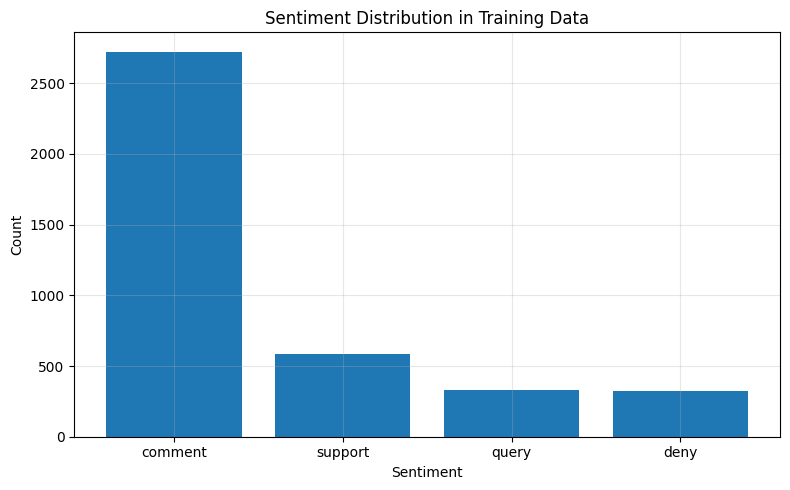

In [ ]:
sentiment_counts = df_train['sentiment'].value_counts()

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(sentiment_counts.index, sentiment_counts.values)
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
ax.set_title('Sentiment Distribution in Training Data')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Do some preprocessing to remove unnecessary information (like urls and mentions)

In [8]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'@\w+', '', text)
    text = text.lower()
    text = ' '.join(word for word in text.split() if not word.startswith('http'))
    text = text.translate(str.maketrans('', '', string.punctuation))

    return text

df_train['processed_text'] = df_train['text'].apply(preprocess_text)
df_train['processed_source_text'] = df_train['source_tweet_text'].apply(preprocess_text)
df_test['processed_text'] = df_test['text'].apply(preprocess_text)
df_test['processed_source_text'] = df_test['source_tweet_text'].apply(preprocess_text)

In [9]:
df_train.head()

,tweet_id,source_tweet_id,source_tweet_text,topic,text,sentiment,source_tweet_sentiment,processed_text,processed_source_text
0,553549946738446336,553543369604210689,An 11-month old baby is among the hostages at ...,charliehebdo,@PD28 @BklynMiddleton Hashtag #kosher shows lo...,query,support,hashtag kosher shows lots of journalists are r...,an 11month old baby is among the hostages at t...
1,553547724860456961,553543369604210689,An 11-month old baby is among the hostages at ...,charliehebdo,*Mutes Universe*,comment,support,mutes universe,an 11month old baby is among the hostages at t...
2,553551580801536000,553543369604210689,An 11-month old baby is among the hostages at ...,charliehebdo,@BklynMiddleton rather than being a 'lone-wolf...,query,support,rather than being a lonewolf copycat the fact ...,an 11month old baby is among the hostages at t...
3,553553099470946304,553543369604210689,An 11-month old baby is among the hostages at ...,charliehebdo,@PD28 @BklynMiddleton No problem! Wish it were...,comment,support,no problem wish it werent such a horrible situ...,an 11month old baby is among the hostages at t...
4,553544770430464000,553543369604210689,An 11-month old baby is among the hostages at ...,charliehebdo,RT @BklynMiddleton: An 11-month old baby is am...,support,support,rt an 11month old baby is among the hostages ...,an 11month old baby is among the hostages at t...


In [10]:
df_test.head()

,tweet_id,source_tweet_id,source_tweet_text,topic,text,sentiment,source_tweet_sentiment,processed_text,processed_source_text
0,580325976975896577,580325090367315968,"Flight #4U9525 initially climbed to 38,000 fee...",germanwings-crash,@flightradar24 Any ATC available? Strange.....,query,support,any atc available strange,flight 4u9525 initially climbed to 38000 feet ...
1,581174677554380800,580325090367315968,"Flight #4U9525 initially climbed to 38,000 fee...",germanwings-crash,@marcepa49 The autopilot wasn't set to 100 fee...,support,support,the autopilot wasnt set to 100 feet it was flo...,flight 4u9525 initially climbed to 38000 feet ...
2,581198171176480768,580325090367315968,"Flight #4U9525 initially climbed to 38,000 fee...",germanwings-crash,"@marcepa49 But that's the FMC, doesn't mean au...",comment,support,but thats the fmc doesnt mean autopilot was en...,flight 4u9525 initially climbed to 38000 feet ...
3,581034556964245504,580325090367315968,"Flight #4U9525 initially climbed to 38,000 fee...",germanwings-crash,@marcepa49 @flightradar24 @isobelroe I don't t...,comment,support,i dont think the autopilot was engaged,flight 4u9525 initially climbed to 38000 feet ...
4,581075660690575360,580325090367315968,"Flight #4U9525 initially climbed to 38,000 fee...",germanwings-crash,@Minus777 @flightradar24 @isobelroe Autopilot ...,comment,support,autopilot was manually changed from 38000 to 1...,flight 4u9525 initially climbed to 38000 feet ...


# Analytics

## Unigrams/Bigrams summary

Get the Unigrams and Bigrams tokens

In [11]:
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
twitter_stopwords = {
    'rt', 'via', 'amp',
    'im', 'ive', 'id', 'theyve',
}
stop_words.update(twitter_stopwords)

unigram_vectorizer = CountVectorizer(
    stop_words=list(stop_words),
    max_features=1000,
    ngram_range=(1, 1)
)

# NLTK stopwords are too aggressive for bigrams
bigram_vectorizer = CountVectorizer(
    stop_words="english",
    max_features=1000,
    ngram_range=(2, 2)
)

stance_labels = sorted(df_train['sentiment'].unique())

ngram_data = {
    'unigrams': {},
    'bigrams': {},
    'top_unigrams_summary': {},
    'top_bigrams_summary': {}
}

for label in stance_labels:
    label_tweets = df_train[df_train['sentiment'] == label]
    label_texts = label_tweets['processed_text'].tolist()
    
    # Compute unigrams
    unigram_counts = unigram_vectorizer.fit_transform(label_texts)
    unigram_sums = unigram_counts.sum(axis=0)
    unigram_freq = [(word, unigram_sums[0, idx]) for word, idx in unigram_vectorizer.vocabulary_.items()]
    unigram_freq_sorted = sorted(unigram_freq, key=lambda x: x[1], reverse=True)
    ngram_data['unigrams'][label] = unigram_freq_sorted
    ngram_data['top_unigrams_summary'][label] = [word for word, _ in unigram_freq_sorted[:5]]

    
    # Compute bigrams
    bigram_counts = bigram_vectorizer.fit_transform(label_texts)
    bigram_sums = bigram_counts.sum(axis=0)
    bigram_freq = [(bigram, bigram_sums[0, idx]) for bigram, idx in bigram_vectorizer.vocabulary_.items()]
    bigram_freq_sorted = sorted(bigram_freq, key=lambda x: x[1], reverse=True)
    ngram_data['bigrams'][label] = bigram_freq_sorted
    ngram_data['top_bigrams_summary'][label] = [bigram for bigram, _ in bigram_freq_sorted[:5]]

# Create summary DataFrames
summary_unigram_df_train = pd.DataFrame(ngram_data['top_unigrams_summary'])
summary_bigram_df_train = pd.DataFrame(ngram_data['top_bigrams_summary'])


Unigram breakdown

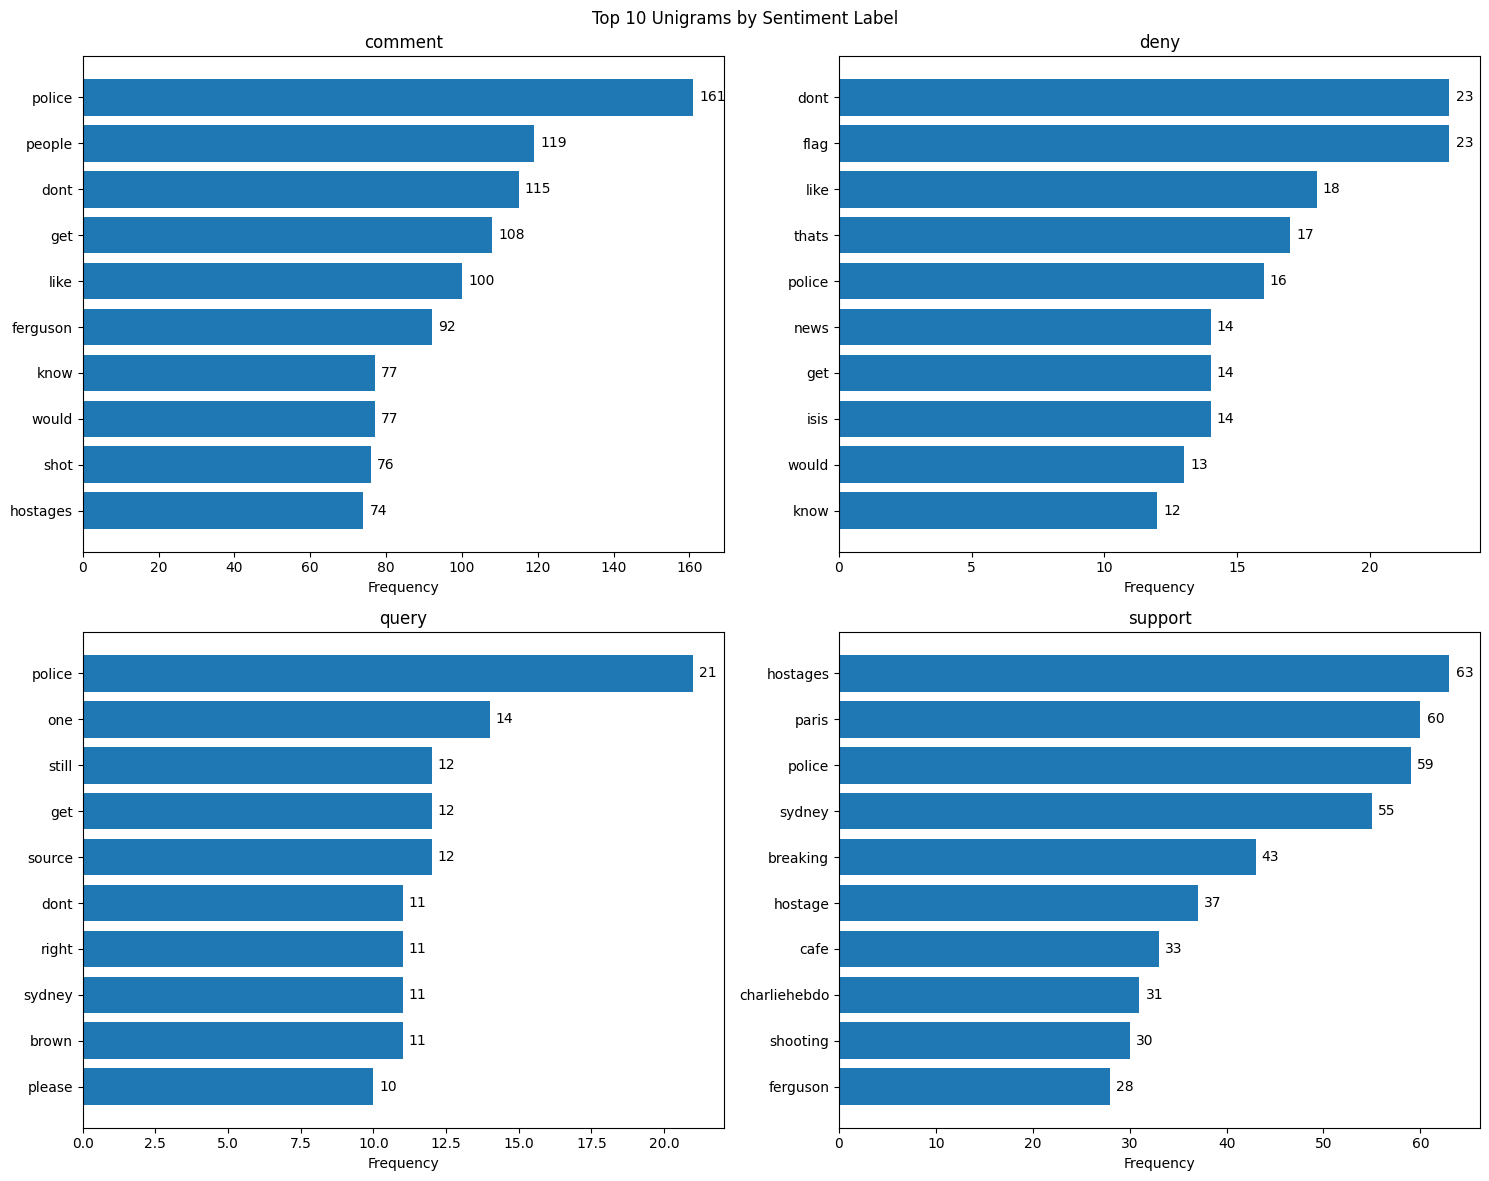

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Top 10 Unigrams by Sentiment Label')
axes = axes.flatten()

for idx, label in enumerate(stance_labels):
    if label in ngram_data['unigrams'] and ngram_data['unigrams'][label]:
        words, freqs = zip(*ngram_data['unigrams'][label][:10])
        ax = axes[idx]
        bars = ax.barh(range(len(words)), freqs)
        ax.set_yticks(range(len(words)))
        ax.set_yticklabels(words)
        ax.invert_yaxis()
        ax.set_xlabel('Frequency')
        ax.set_title(f'{label}')
        
        # Add frequency values on bars
        for bar in bars:
            width = bar.get_width()
            ax.text(width + max(freqs)*0.01, bar.get_y() + bar.get_height()/2, 
                   f'{int(width)}', va='center')

plt.tight_layout()
plt.show()

Bigram breakdown

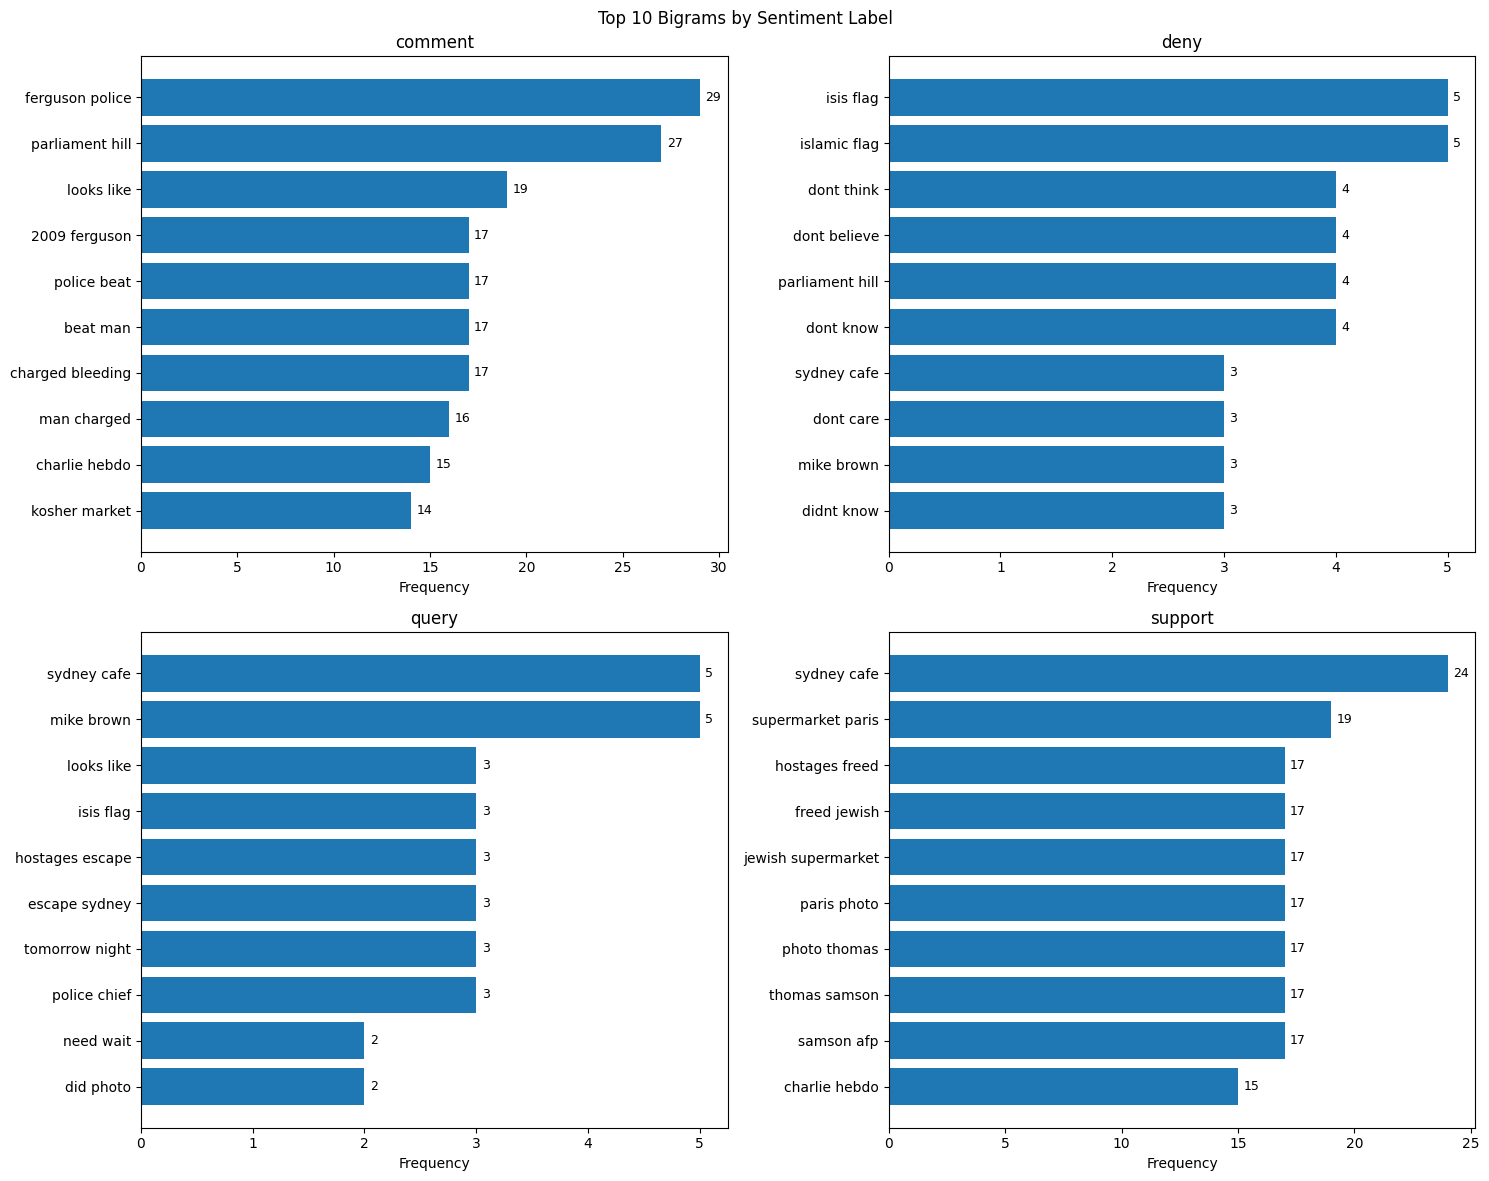

In [13]:
fig2, axes2 = plt.subplots(2, 2, figsize=(15, 12))
fig2.suptitle('Top 10 Bigrams by Sentiment Label')
axes2 = axes2.flatten()

for idx, label in enumerate(stance_labels):
    if label in ngram_data['bigrams'] and ngram_data['bigrams'][label]:
        bigrams, freqs = zip(*ngram_data['bigrams'][label][:10])
        ax = axes2[idx]
        bars = ax.barh(range(len(bigrams)), freqs)
        ax.set_yticks(range(len(bigrams)))
        ax.set_yticklabels(bigrams)
        ax.invert_yaxis()
        ax.set_xlabel('Frequency')
        ax.set_title(f'{label}')
        
        # Add frequency values on bars
        for bar in bars:
            width = bar.get_width()
            ax.text(width + max(freqs)*0.01, bar.get_y() + bar.get_height()/2, 
                   f'{int(width)}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

Get token distribution for stance vs non-stance

For source tweets

In [14]:
unique_sources = df_train.drop_duplicates(subset=['source_tweet_id']).copy()
unique_sources['is_stance'] = unique_sources['source_tweet_sentiment'].isin(['support', 'deny', 'query'])

stance_source_texts = unique_sources[unique_sources['is_stance']]['processed_source_text'].tolist()
non_stance_source_texts = unique_sources[~unique_sources['is_stance']]['processed_source_text'].tolist()

source_vectorizer = CountVectorizer(
    stop_words=list(stop_words),
    max_features=20,
    ngram_range=(1, 1)
)

all_source_texts = stance_source_texts + non_stance_source_texts
source_vectorizer.fit(all_source_texts)

stance_source_counts = source_vectorizer.transform(stance_source_texts).sum(axis=0)
non_stance_source_counts = source_vectorizer.transform(non_stance_source_texts).sum(axis=0)
feature_names = source_vectorizer.get_feature_names_out()

source_comparison = []
for i, feature in enumerate(feature_names):
    stance_freq = stance_source_counts[0, i]
    non_stance_freq = non_stance_source_counts[0, i]
    
    stance_norm = stance_freq / len(stance_source_texts) if len(stance_source_texts) > 0 else 0
    non_stance_norm = non_stance_freq / len(non_stance_source_texts) if len(non_stance_source_texts) > 0 else 0
    
    source_comparison.append({
        'unigram': feature,
        'stance_freq': stance_freq,
        'non_stance_freq': non_stance_freq,
        'stance_norm': stance_norm,
        'non_stance_norm': non_stance_norm
    })

source_comparison_df_train = pd.DataFrame(source_comparison)
source_comparison_df_train['total_freq'] = source_comparison_df_train['stance_freq'] + source_comparison_df_train['non_stance_freq']
source_comparison_df_train = source_comparison_df_train.sort_values('total_freq', ascending=False)

For reply tweets

In [15]:
df_train['is_stance_reply'] = df_train['sentiment'].isin(['support', 'deny', 'query'])
stance_reply_texts = df_train[df_train['is_stance_reply']]['processed_text'].tolist()
non_stance_reply_texts = df_train[~df_train['is_stance_reply']]['processed_text'].tolist()


reply_vectorizer = CountVectorizer(
    stop_words=list(stop_words),
    max_features=20,
    ngram_range=(1, 1)
)

all_reply_texts = stance_reply_texts + non_stance_reply_texts
reply_vectorizer.fit(all_reply_texts)

stance_reply_counts = reply_vectorizer.transform(stance_reply_texts).sum(axis=0)
non_stance_reply_counts = reply_vectorizer.transform(non_stance_reply_texts).sum(axis=0)
reply_feature_names = reply_vectorizer.get_feature_names_out()

reply_comparison = []
for i, feature in enumerate(reply_feature_names):
    stance_freq = stance_reply_counts[0, i]
    non_stance_freq = non_stance_reply_counts[0, i]
    
    stance_norm = stance_freq / len(stance_reply_texts) if len(stance_reply_texts) > 0 else 0
    non_stance_norm = non_stance_freq / len(non_stance_reply_texts) if len(non_stance_reply_texts) > 0 else 0
    
    reply_comparison.append({
        'unigram': feature,
        'stance_freq': stance_freq,
        'non_stance_freq': non_stance_freq,
        'stance_norm': stance_norm,
        'non_stance_norm': non_stance_norm
    })

reply_comparison_df_train = pd.DataFrame(reply_comparison)
reply_comparison_df_train['total_freq'] = reply_comparison_df_train['stance_freq'] + reply_comparison_df_train['non_stance_freq']
reply_comparison_df_train = reply_comparison_df_train.sort_values('total_freq', ascending=False)

Plot token distribution

For source tweets

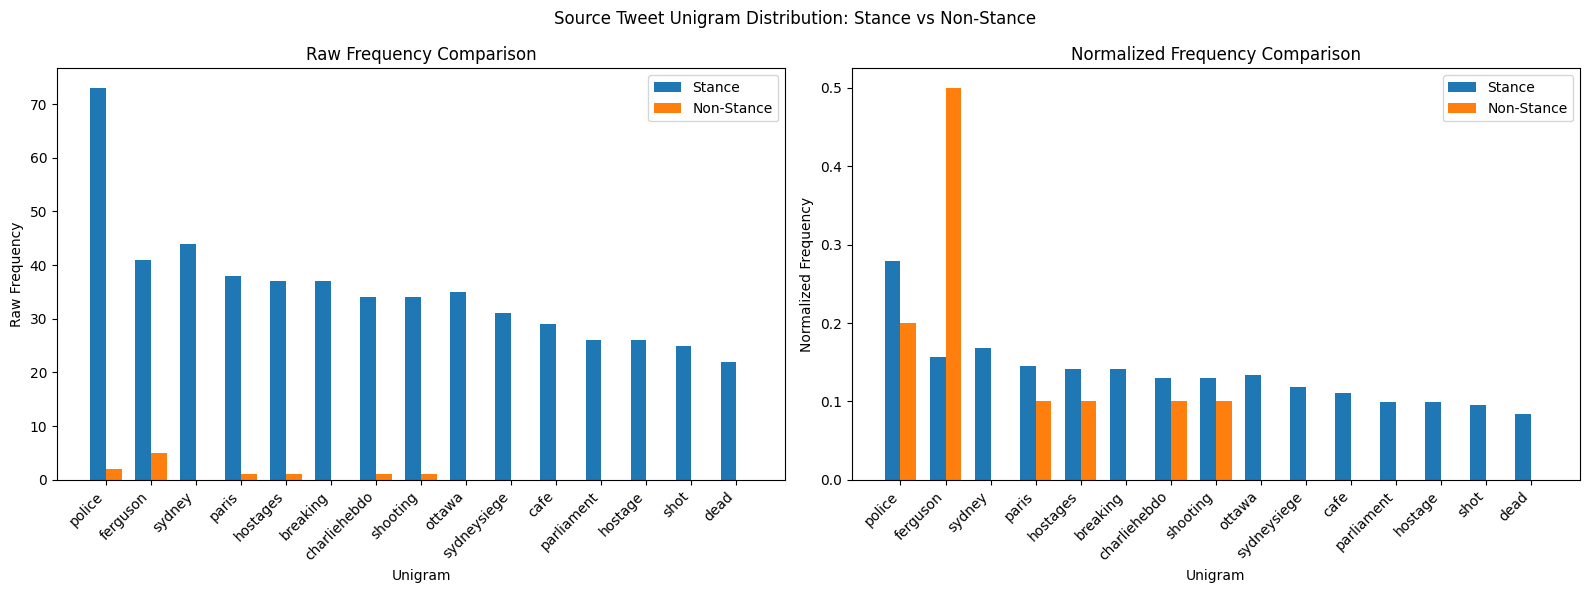

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Source Tweet Unigram Distribution: Stance vs Non-Stance')

# Raw frequency
top_n = 15
top_source_unigrams = source_comparison_df_train.head(top_n)['unigram'].values
top_source_stance = source_comparison_df_train.head(top_n)['stance_freq'].values
top_source_non_stance = source_comparison_df_train.head(top_n)['non_stance_freq'].values

x = np.arange(len(top_source_unigrams))
width = 0.35

ax1.bar(x - width/2, top_source_stance, width, label='Stance')
ax1.bar(x + width/2, top_source_non_stance, width, label='Non-Stance')
ax1.set_xlabel('Unigram')
ax1.set_ylabel('Raw Frequency')
ax1.set_title('Raw Frequency Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(top_source_unigrams, rotation=45, ha='right')
ax1.legend()

# Normalized frequency
top_source_stance_norm = source_comparison_df_train.head(top_n)['stance_norm'].values
top_source_non_stance_norm = source_comparison_df_train.head(top_n)['non_stance_norm'].values

ax2.bar(x - width/2, top_source_stance_norm, width, label='Stance')
ax2.bar(x + width/2, top_source_non_stance_norm, width, label='Non-Stance')
ax2.set_xlabel('Unigram')
ax2.set_ylabel('Normalized Frequency')
ax2.set_title('Normalized Frequency Comparison')
ax2.set_xticks(x)
ax2.set_xticklabels(top_source_unigrams, rotation=45, ha='right')
ax2.legend()

plt.tight_layout()
plt.show()

For reply tweets

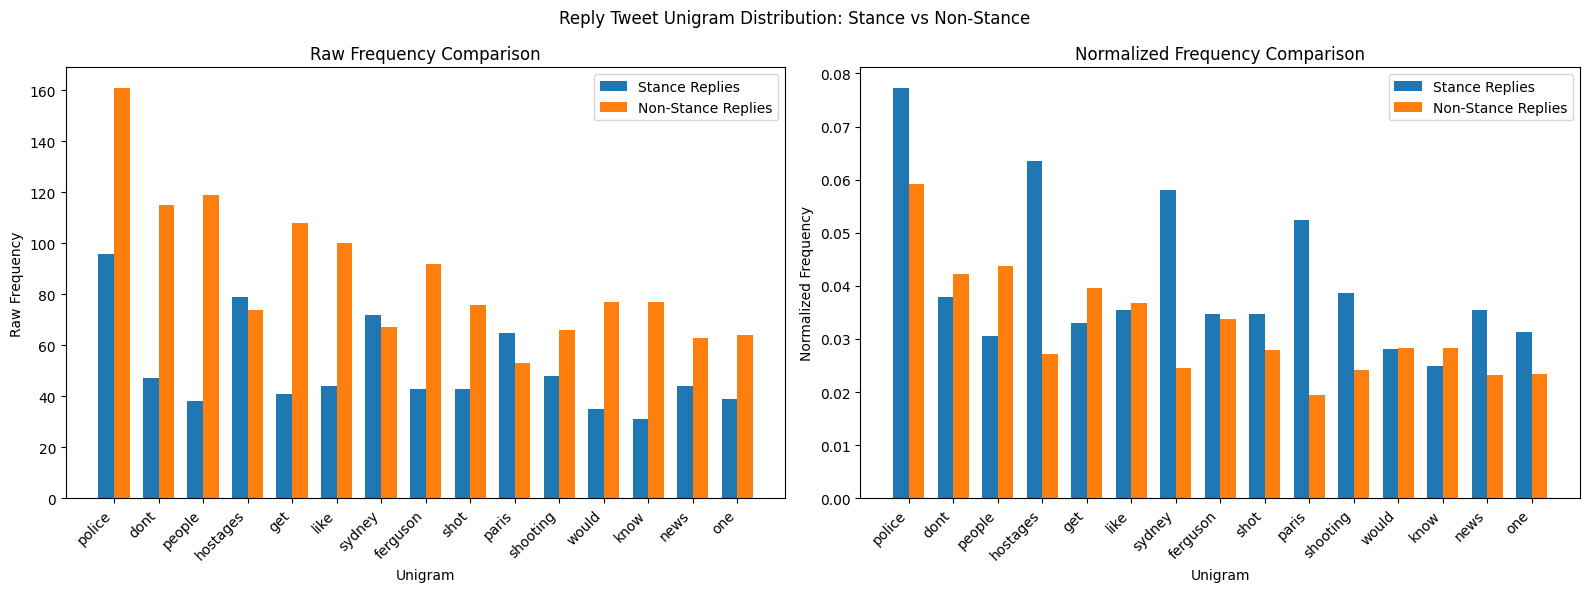

In [17]:
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Reply Tweet Unigram Distribution: Stance vs Non-Stance')

# Raw frequency
top_reply_unigrams = reply_comparison_df_train.head(top_n)['unigram'].values
top_reply_stance = reply_comparison_df_train.head(top_n)['stance_freq'].values
top_reply_non_stance = reply_comparison_df_train.head(top_n)['non_stance_freq'].values

x_reply = np.arange(len(top_reply_unigrams))

ax3.bar(x_reply - width/2, top_reply_stance, width, label='Stance Replies')
ax3.bar(x_reply + width/2, top_reply_non_stance, width, label='Non-Stance Replies')
ax3.set_xlabel('Unigram')
ax3.set_ylabel('Raw Frequency')
ax3.set_title('Raw Frequency Comparison')
ax3.set_xticks(x_reply)
ax3.set_xticklabels(top_reply_unigrams, rotation=45, ha='right')
ax3.legend()

# Normalized frequency
top_reply_stance_norm = reply_comparison_df_train.head(top_n)['stance_norm'].values
top_reply_non_stance_norm = reply_comparison_df_train.head(top_n)['non_stance_norm'].values

ax4.bar(x_reply - width/2, top_reply_stance_norm, width, label='Stance Replies')
ax4.bar(x_reply + width/2, top_reply_non_stance_norm, width, label='Non-Stance Replies')
ax4.set_xlabel('Unigram')
ax4.set_ylabel('Normalized Frequency')
ax4.set_title('Normalized Frequency Comparison')
ax4.set_xticks(x_reply)
ax4.set_xticklabels(top_reply_unigrams, rotation=45, ha='right')
ax4.legend()

plt.tight_layout()
plt.show()

## LDA

Set an arbitrary amout of topics to be grouping for

In [18]:
n_topics = 3

Helper code for wordcloud generation

In [19]:
def create_topic_wordcloud(topic_weights, feature_names, n_words=50):
    top_indices = topic_weights.argsort()[-n_words:][::-1]
    word_weights = {feature_names[i]: topic_weights[i] for i in top_indices}
    
    return WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=n_words
    ).generate_from_frequencies(word_weights)

Fitting LDA on stance replies and show word cloud

Document-term matrix shape: (1242, 1000)


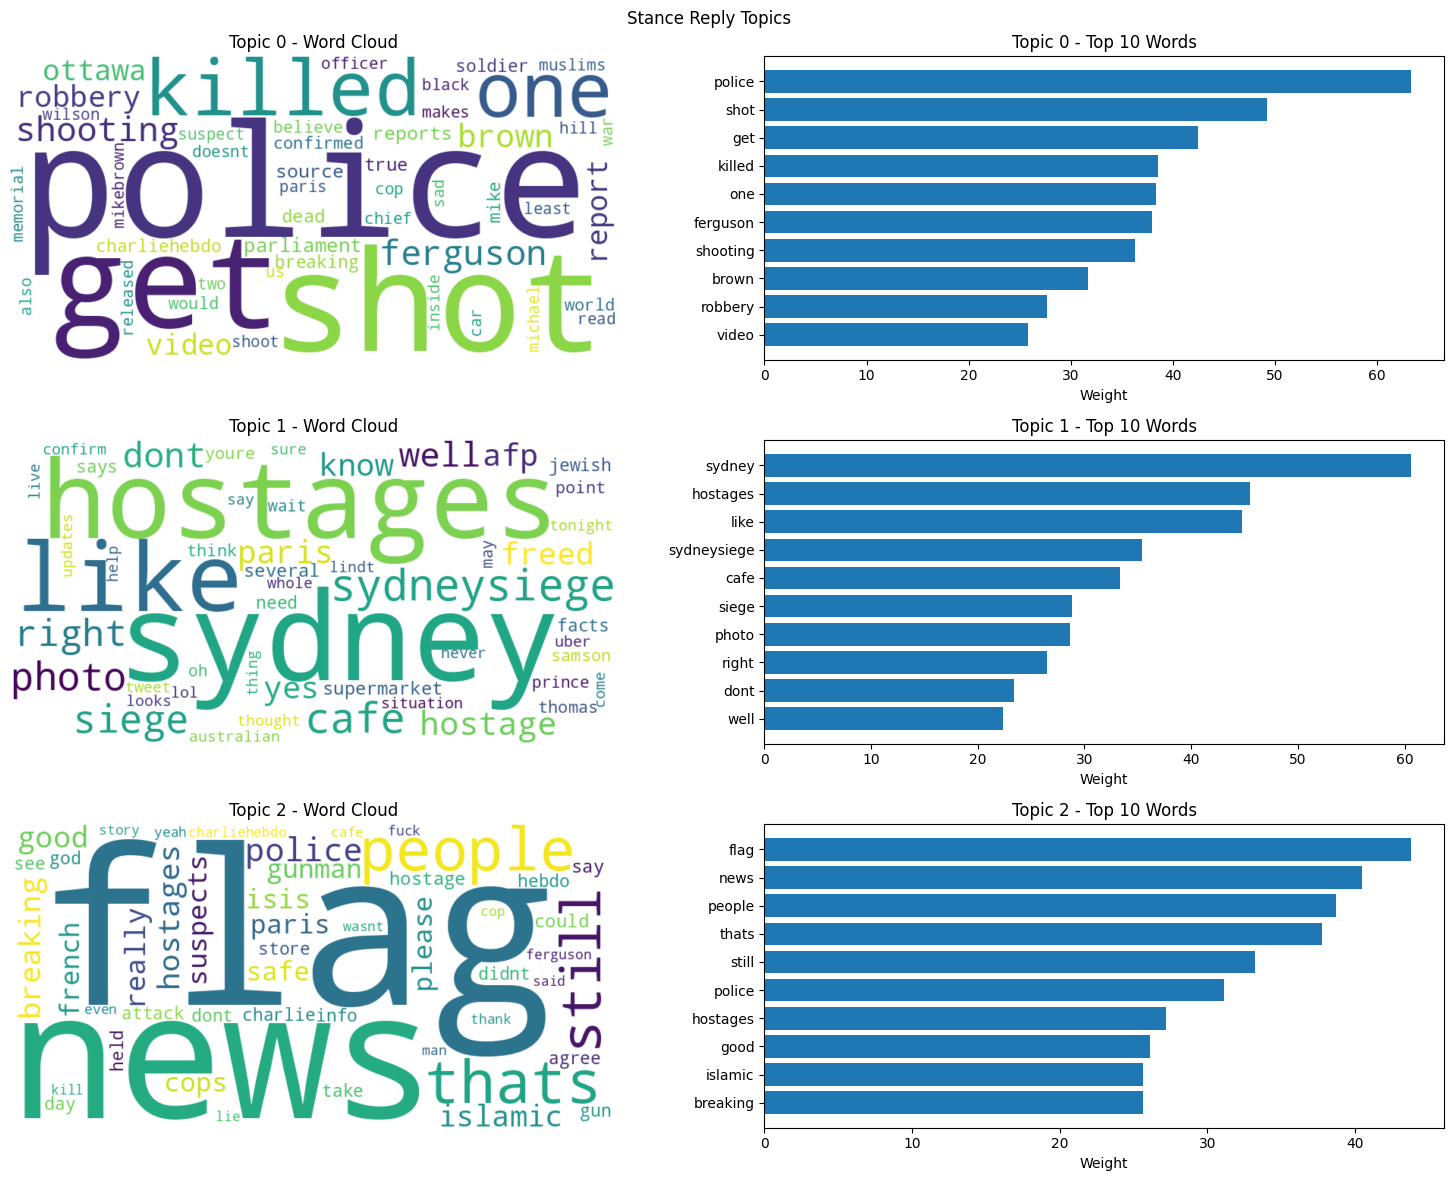

In [20]:
# LDA for stance replies
stance_vectorizer = CountVectorizer(
    max_features=1000,
    stop_words=list(stop_words),
    max_df=0.90,
    min_df=2,
)
stance_dtm = stance_vectorizer.fit_transform(stance_reply_texts)
print(f"Document-term matrix shape: {stance_dtm.shape}")

lda_stance = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method='online',
    max_iter=10
)
lda_stance.fit_transform(stance_dtm)
stance_feature_names = stance_vectorizer.get_feature_names_out()

fig1, axes1 = plt.subplots(n_topics, 2, figsize=(15, 4*n_topics))
fig1.suptitle('Stance Reply Topics')

for topic_idx in range(n_topics):
    topic_weights = lda_stance.components_[topic_idx]
    
    # Word cloud
    wordcloud = create_topic_wordcloud(topic_weights, stance_feature_names)
    axes1[topic_idx, 0].imshow(wordcloud, interpolation='bilinear')
    axes1[topic_idx, 0].axis('off')
    axes1[topic_idx, 0].set_title(f'Topic {topic_idx} - Word Cloud')
    
    # Top words list
    top_words_idx = topic_weights.argsort()[:-11:-1]
    top_words = [stance_feature_names[i] for i in top_words_idx]
    top_weights = [topic_weights[i] for i in top_words_idx]
    
    axes1[topic_idx, 1].barh(range(len(top_words)), top_weights[::-1])
    axes1[topic_idx, 1].set_yticks(range(len(top_words)))
    axes1[topic_idx, 1].set_yticklabels(top_words[::-1])
    axes1[topic_idx, 1].set_xlabel('Weight')
    axes1[topic_idx, 1].set_title(f'Topic {topic_idx} - Top 10 Words')

plt.tight_layout()
plt.show()

Fitting LDA for non-stance replies and show word cloud

Document-term matrix shape: (2724, 1000)


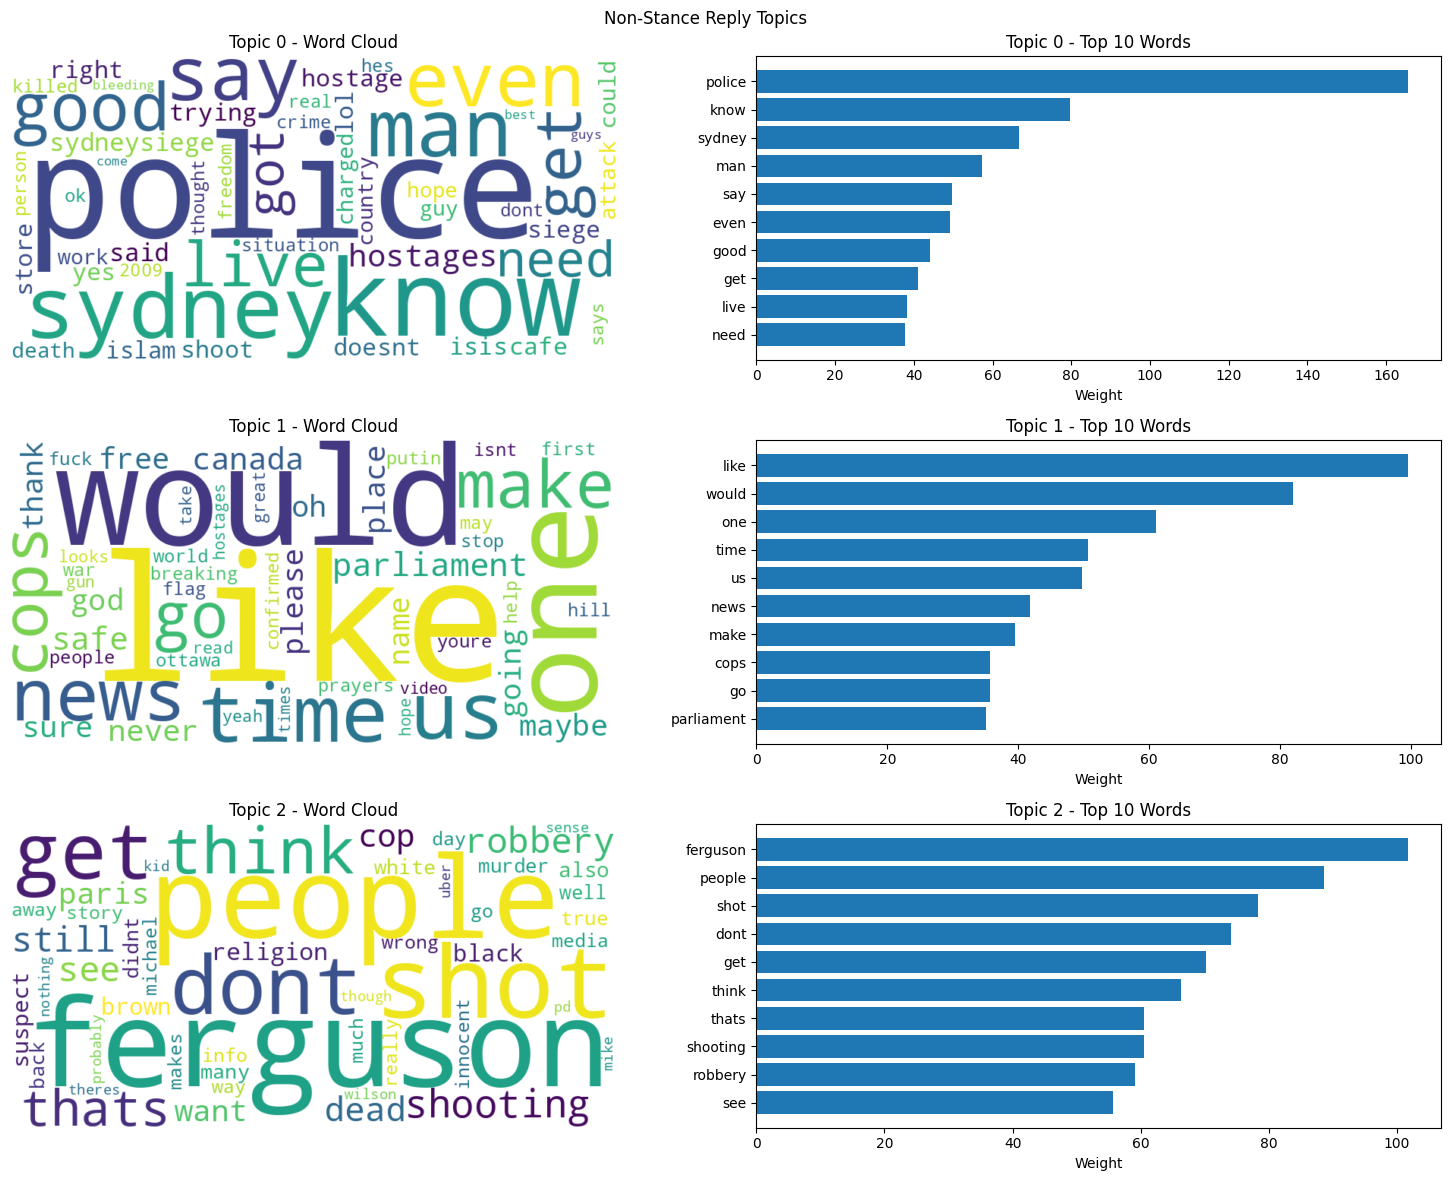

In [21]:
# LDA for non-stance replies
non_stance_vectorizer = CountVectorizer(
    max_features=1000,
    stop_words=list(stop_words),
    max_df=0.90,
    min_df=2,
)
non_stance_dtm = non_stance_vectorizer.fit_transform(non_stance_reply_texts)
print(f"Document-term matrix shape: {non_stance_dtm.shape}")

lda_non_stance = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method='online',
    max_iter=10
)
lda_non_stance.fit_transform(non_stance_dtm)
non_stance_feature_names = non_stance_vectorizer.get_feature_names_out()

fig2, axes2 = plt.subplots(n_topics, 2, figsize=(15, 4*n_topics))
fig2.suptitle('Non-Stance Reply Topics')

for topic_idx in range(n_topics):
    topic_weights = lda_non_stance.components_[topic_idx]
    
    # Word cloud
    wordcloud = create_topic_wordcloud(topic_weights, non_stance_feature_names)
    axes2[topic_idx, 0].imshow(wordcloud, interpolation='bilinear')
    axes2[topic_idx, 0].axis('off')
    axes2[topic_idx, 0].set_title(f'Topic {topic_idx} - Word Cloud')
    
    # Top words list
    top_words_idx = topic_weights.argsort()[:-11:-1]
    top_words = [non_stance_feature_names[i] for i in top_words_idx]
    top_weights = [topic_weights[i] for i in top_words_idx]
    
    axes2[topic_idx, 1].barh(range(len(top_words)), top_weights[::-1])
    axes2[topic_idx, 1].set_yticks(range(len(top_words)))
    axes2[topic_idx, 1].set_yticklabels(top_words[::-1])
    axes2[topic_idx, 1].set_xlabel('Weight')
    axes2[topic_idx, 1].set_title(f'Topic {topic_idx} - Top 10 Words')

plt.tight_layout()
plt.show()

# Classification

## 4-way Classification

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

label2id = {'support': 0, 'deny': 1, 'query': 2, 'comment': 3}
id2label = {v: k for k, v in label2id.items()}

class TweetDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Format input: "Source [CONTENT]  Reply: [CONTENT]"
        text = f"Source: {row['source_tweet_text']} Reply: {row['text']}"
        
        # Tokenize
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        label = label2id[row['sentiment']]
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


# Split train into train/eval (80/20)
train_df, val_df = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train['sentiment'])

train_dataset = TweetDataset(train_df, tokenizer)
val_dataset = TweetDataset(val_df, tokenizer)
test_dataset = TweetDataset(df_test, tokenizer)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=4,
    id2label=id2label,
    label2id=label2id
)
model.to(device)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    
    return {
        'accuracy': accuracy,
        'f1': f1,
    }

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    seed=42,
    fp16=torch.cuda.is_available(),
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

train_results = trainer.train()

Device: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train samples: 3172
Val samples: 794
Test samples: 256


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.786700,0.853788,0.695214,0.242407
2,0.825500,0.802002,0.715365,0.400356
3,0.595200,0.826826,0.695214,0.490755
4,0.410000,0.956886,0.704030,0.482001
5,0.198100,1.115635,0.701511,0.484688


Evaluation data with training loss:
   epoch  train_loss  eval_loss   eval_f1
0    1.0    0.845575   0.853788  0.242407
1    2.0    0.713005   0.802002  0.400356
2    3.0    0.509980   0.826826  0.490755
3    4.0    0.302930   0.956886  0.482001
4    5.0    0.194720   1.115635  0.484688


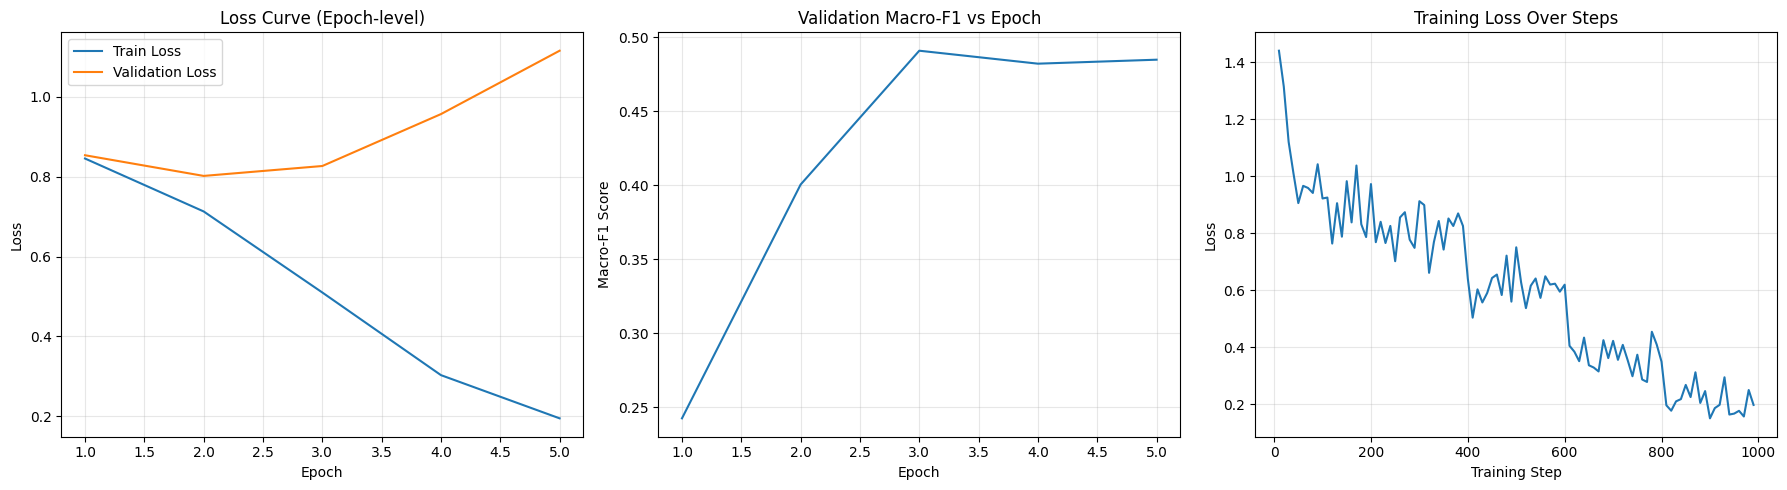

In [73]:
eval_df = pd.DataFrame([log for log in trainer.state.log_history if 'eval_loss' in log])
train_data = pd.DataFrame([log for log in trainer.state.log_history if 'loss' in log and 'eval_loss' not in log])

# For each evaluation epoch, get average training loss from nearby training logs
train_loss_by_eval_epoch = []
for eval_epoch in eval_df['epoch']:
    # Find training logs close to this evaluation epoch (within 0.5)
    nearby_train = train_data[(train_data['epoch'] >= eval_epoch - 0.5) & 
                              (train_data['epoch'] < eval_epoch + 0.5)]
    avg_loss = nearby_train['loss'].mean() if len(nearby_train) > 0 else None
    train_loss_by_eval_epoch.append(avg_loss)

eval_df['train_loss'] = train_loss_by_eval_epoch

print("Evaluation data with training loss:")
print(eval_df[['epoch', 'train_loss', 'eval_loss', 'eval_f1']].to_string())

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Loss curve
ax1.plot(eval_df['epoch'], eval_df['train_loss'], label='Train Loss')
ax1.plot(eval_df['epoch'], eval_df['eval_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve (Epoch-level)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Validation F1
ax2.plot(eval_df['epoch'], eval_df['eval_f1'])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Macro-F1 Score')
ax2.set_title('Validation Macro-F1 vs Epoch')
ax2.grid(True, alpha=0.3)

# Training loss over steps
ax3.plot(train_data['step'], train_data['loss'])
ax3.set_xlabel('Training Step')
ax3.set_ylabel('Loss')
ax3.set_title('Training Loss Over Steps')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

     support       0.39      0.39      0.39        46
        deny       0.20      0.20      0.20        10
       query       0.85      0.61      0.71        28
     comment       0.77      0.80      0.78       172

    accuracy                           0.68       256
   macro avg       0.55      0.50      0.52       256
weighted avg       0.69      0.68      0.68       256



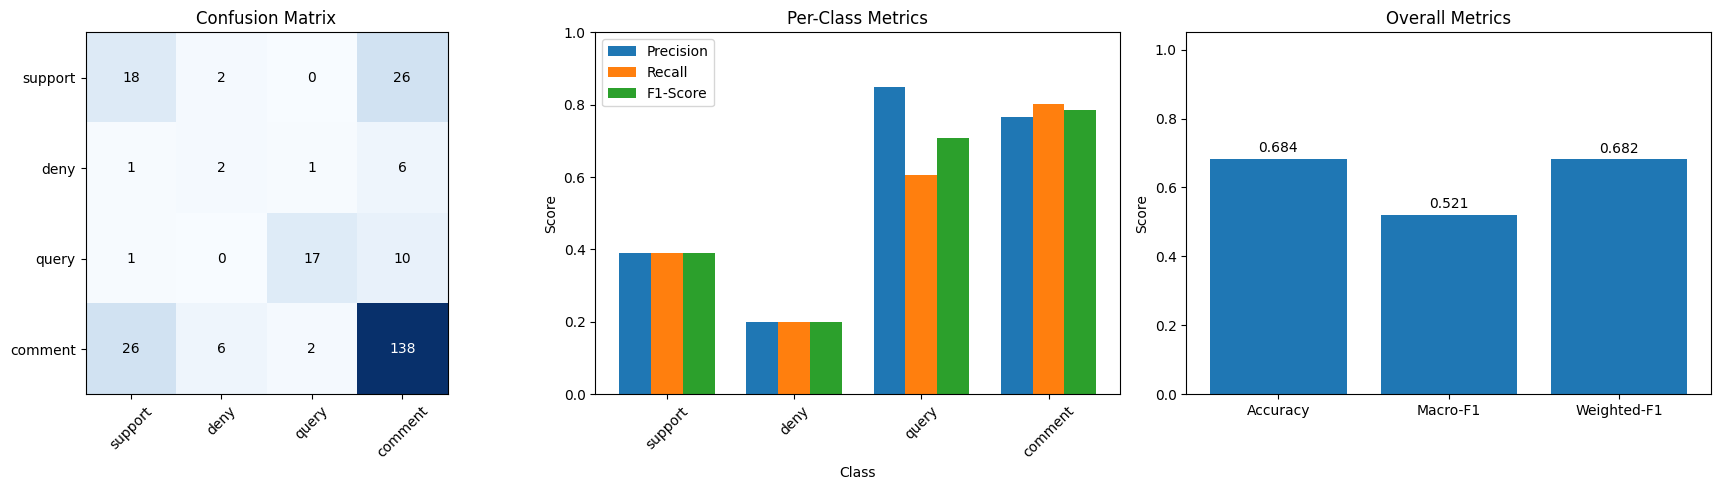

Test Accuracy: 0.6836
Macro-F1: 0.5209
Weighted-F1: 0.6824


In [137]:
test_predictions = trainer.predict(test_dataset)
preds = np.argmax(test_predictions.predictions, axis=1)
labels = test_predictions.label_ids
report = classification_report(labels, preds, target_names=['support', 'deny', 'query', 'comment'], output_dict=True)
print(classification_report(labels, preds, target_names=['support', 'deny', 'query', 'comment']))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion Matrix
cm = confusion_matrix(labels, preds)
im = axes[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[0].set_title('Confusion Matrix')
axes[0].set_xticks(range(4))
axes[0].set_yticks(range(4))
axes[0].set_xticklabels(['support', 'deny', 'query', 'comment'], rotation=45)
axes[0].set_yticklabels(['support', 'deny', 'query', 'comment'])

for i in range(4):
    for j in range(4):
        axes[0].text(j, i, str(cm[i, j]), ha='center', va='center', 
                    color='white' if cm[i, j] > cm.max()/2 else 'black')

# Per-class Metrics Bar Chart
classes = ['support', 'deny', 'query', 'comment']
precisions = [report[cls]['precision'] for cls in classes]
recalls = [report[cls]['recall'] for cls in classes]
f1_scores = [report[cls]['f1-score'] for cls in classes]

x = np.arange(len(classes))
width = 0.25

axes[1].bar(x - width, precisions, width, label='Precision')
axes[1].bar(x, recalls, width, label='Recall')
axes[1].bar(x + width, f1_scores, width, label='F1-Score')

axes[1].set_xlabel('Class')
axes[1].set_ylabel('Score')
axes[1].set_title('Per-Class Metrics')
axes[1].set_xticks(x)
axes[1].set_xticklabels(classes, rotation=45)
axes[1].legend()
axes[1].set_ylim([0, 1.0])

# Overall Metrics Comparison
overall_metrics = ['Accuracy', 'Macro-F1', 'Weighted-F1']
overall_values = [
    report['accuracy'],
    report['macro avg']['f1-score'],
    report['weighted avg']['f1-score']
]

bars = axes[2].bar(overall_metrics, overall_values)
axes[2].set_ylabel('Score')
axes[2].set_title('Overall Metrics')
axes[2].set_ylim([0, 1.05])

for bar, value in zip(bars, overall_values):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"Test Accuracy: {report['accuracy']:.4f}")
print(f"Macro-F1: {report['macro avg']['f1-score']:.4f}")
print(f"Weighted-F1: {report['weighted avg']['f1-score']:.4f}")

## Model Prompting

In [163]:
model_name = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Note to self: How to proompt
# - Use answer instead of anything else at the end
# - Keep it very short
# - Dont persona and context
def classify_zero_shot(source_text, reply_text):
    prompt = f"""Classify: support, deny, query, or comment?
Source: {source_text[:80]} 
Reply: {reply_text[:80]}

Answer:"""
    
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=256).to(device)
    outputs = model.generate(
        **inputs, 
        max_new_tokens=1,
        do_sample=False,
        temperature=0.0
    )
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    prediction = prediction.strip().lower()
    
    if prediction in ['support', 'deny', 'query', 'comment']:
        return prediction
    
    words = prediction.split()
    if words and words[0] in ['support', 'deny', 'query', 'comment']:
        return words[0]
    
    return 'comment'

def classify_few_shot(source_text, reply_text):
    # Add simple examples before the query
    prompt = f"""Classify: support, deny, query, or comment?
Source: Good news Reply: Agree Answer: support
Source: Earth flat Reply: WRONG STUPID DUMB????! Answer: deny
Source: Market crashed Reply: Why? Answer: query
Source: I'm hungry Reply: Me too Answer: comment

Source: {source_text[:80]}
Reply: {reply_text[:80]}
Answer:"""
    
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)
    outputs = model.generate(
        **inputs, 
        max_new_tokens=1,
        do_sample=False,
        temperature=0.0
    )
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    prediction = prediction.strip().lower()
    
    if prediction in ['support', 'deny', 'query', 'comment']:
        return prediction
    
    words = prediction.split()
    if words and words[0] in ['support', 'deny', 'query', 'comment']:
        return words[0]
    
    return 'comment'

# Batch classification function
def classify_batch(df_sample, few_shot=False):
    predictions = []
    
    for _, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
        source = row['source_tweet_text']
        reply = row['text']
        
        if few_shot:
            pred = classify_few_shot(source, reply)
        else:
            pred = classify_zero_shot(source, reply)
        
        predictions.append(pred)
    
    df_sample['predicted_sentiment'] = predictions
    return df_sample

print("Zero-shot")
zero_shot_results = classify_batch(df_test.copy(), few_shot=False)

print("Few-shot")
few_shot_results = classify_batch(df_test.copy(), few_shot=True)

print("\nZero-shot Results:")
print(classification_report(zero_shot_results['sentiment'], 
                          zero_shot_results['predicted_sentiment'],
                          target_names=['support', 'deny', 'query', 'comment'],
                          zero_division=0))

print("\nFew-shot Results:")
print(classification_report(few_shot_results['sentiment'], 
                          few_shot_results['predicted_sentiment'],
                          target_names=['support', 'deny', 'query', 'comment'],
                          zero_division=0))

Zero-shot


100%|██████████| 256/256 [00:09<00:00, 27.48it/s]


Few-shot


100%|██████████| 256/256 [00:08<00:00, 31.02it/s]


Zero-shot Results:
              precision    recall  f1-score   support

     support       0.74      0.38      0.51       172
        deny       0.00      0.00      0.00        10
       query       0.76      0.46      0.58        28
     comment       0.23      0.74      0.35        46

    accuracy                           0.44       256
   macro avg       0.43      0.40      0.36       256
weighted avg       0.62      0.44      0.47       256


Few-shot Results:
              precision    recall  f1-score   support

     support       0.78      0.56      0.65       172
        deny       0.00      0.00      0.00        10
       query       0.71      0.54      0.61        28
     comment       0.27      0.65      0.38        46

    accuracy                           0.55       256
   macro avg       0.44      0.44      0.41       256
weighted avg       0.65      0.55      0.57       256



## Chain of thought

In [168]:
def classify_chain_of_thought(source_text, reply_text):
    # Stage 1: Comment vs Non-Comment
    prompt_stage1 = f"""Classify: true, or false?

Tweet: {source_text[:60]}
Reply: {reply_text[:60]}

Answer:"""
    
    inputs1 = tokenizer(prompt_stage1, return_tensors="pt", truncation=True, max_length=256).to(device)
    outputs1 = model.generate(
        **inputs1,
        max_new_tokens=3,
        do_sample=False,
        temperature=0.0
    )
    stage1_pred = tokenizer.decode(outputs1[0], skip_special_tokens=True).strip().lower()
    
    # Check if it's comment
    if 'true' in stage1_pred:
        return 'comment'
    
    # Stage 2: Support vs Deny vs Query
    prompt_stage2 = f"""Classify: support, deny, or query?

Tweet: {source_text[:60]}
Reply: {reply_text[:60]}

Answer:"""
    
    inputs2 = tokenizer(prompt_stage2, return_tensors="pt", truncation=True, max_length=256).to(device)
    outputs2 = model.generate(
        **inputs2,
        max_new_tokens=3,
        do_sample=False,
        temperature=0.0
    )
    stage2_pred = tokenizer.decode(outputs2[0], skip_special_tokens=True).strip().lower()
    
    if stage2_pred in ['support', 'deny', 'query', 'comment']:
        return stage2_pred
    
    words = stage2_pred.split()
    if words and words[0] in ['support', 'deny', 'query', 'comment']:
        return words[0]
    
    return 'comment'

print("Chain-of-Thought")
cot = []
for _, row in tqdm(df_test.iterrows(), total=len(df_test)):
    pred = classify_chain_of_thought(row['source_tweet_text'], row['text'])
    cot.append(pred)

df_cot = df_test.copy()
df_cot['predicted_sentiment'] = cot


print("\nChain of thought results:")
print(classification_report(df_cot['sentiment'], 
                          df_cot['predicted_sentiment'],
                          target_names=['support', 'deny', 'query', 'comment'],
                          zero_division=0))

Chain-of-Thought


100%|██████████| 256/256 [00:19<00:00, 13.37it/s]


Chain of thought results:
              precision    recall  f1-score   support

     support       0.62      0.44      0.52       172
        deny       0.07      0.30      0.11        10
       query       0.62      0.36      0.45        28
     comment       0.19      0.30      0.24        46

    accuracy                           0.40       256
   macro avg       0.38      0.35      0.33       256
weighted avg       0.52      0.40      0.44       256



prompt_stage1 = f"""Classify: fact, or lie?

Tweet: {source_text[:60]}
Reply: {reply_text[:60]}

Answer:"""

Chain of thought results:
              precision    recall  f1-score   support

     support       0.66      0.70      0.68       172
        deny       0.08      0.30      0.13        10
       query       1.00      0.21      0.35        28
     comment       0.21      0.13      0.16        46

    accuracy                           0.53       256
   macro avg       0.49      0.34      0.33       256
weighted avg       0.59      0.53      0.53       256